In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# build the loss function
def loss(t, A, lambda_val, model, loss_term_weights):
            
    # create the trial solution
    u_t = lambda t: A + (1 - torch.exp(-t)) * model(t)

    # find u_0 at t=0 for normalizing loss and use it to compute the normalization factor
    u_0 = u_t(torch.tensor([[0]], dtype=torch.float32))
    norm_term = 1 / u_0 ** 2
    
    # initialize all loss terms in case they do not need to be computed
    L_D, L_DD, L_DDD = torch.tensor([[0.]]), torch.tensor([[0.]]), torch.tensor([[0.]])
    
    # define f (aka forcing function)
    f = lambda t, u: -lambda_val * u 

    # compute u(t)
    outputs = u_t(t)
       
    # compute du / dt
    u_t_x = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]
    
    # original loss function (NOTE: du/dt - f(t, outputs) is the residual)
    L_D = norm_term * loss_term_weights[0] * torch.mean((u_t_x - f(t, outputs)) ** 2)
    
    if loss_term_weights[1] or loss_term_weights[2]:
        
        # define f' (derivative of f)
        f_t = lambda t, u_t_x: -lambda_val * u_t_x

        # compute d^2u / dt^2
        u_tt_x = torch.autograd.grad(u_t_x, t, grad_outputs=torch.ones_like(u_t_x),
                            create_graph=True)[0]

        # first derivative of residual
        L_DD = norm_term * loss_term_weights[1] * torch.mean((u_tt_x - f_t(t, u_t_x)) ** 2)

    if loss_term_weights[2]:
        
        # define f'' (derivative of f')
        f_tt = lambda t, u_tt_x: -lambda_val * u_tt_x

        # compute d^3u / dt^3
        u_ttt_x = torch.autograd.grad(u_tt_x, t, grad_outputs=torch.ones_like(u_tt_x),
                            create_graph=True)[0]
        # second derivative of residual
        L_DDD = norm_term * loss_term_weights[2] * torch.mean((u_ttt_x - f_tt(t, u_tt_x)) ** 2) 

    # total loss terms 
    L_total = L_D + L_DD + L_DDD
    
    return L_D, L_DD, L_DDD, L_total

In [3]:
# build, train, and run the model
def run_model(iterations, min_x, max_x, A, lambda_val, loss_term_weights):
    
    assert sum(loss_term_weights) != 0, "ERROR: Invalid Loss Function"
    
    for idx, num in enumerate(loss_term_weights[:-1]):
        next_num = loss_term_weights[idx + 1]
        assert next_num <= num, 'ERROR: Invalid Loss Function'
        
    # build the neural net model
    model = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64,1)) 
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    L_D_losses, L_DD_losses, L_DDD_losses, L_total_losses = [], [], [], []
    
    start_time = time.time()
    
    # run the training loop
    for i in range(iterations):
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        L_D, L_DD, L_DDD, L_total = loss(x, A, lambda_val, model, loss_term_weights)
        
        # store individual loss terms for plotting
        L_D_losses.append(L_D.item())
        L_DD_losses.append(L_DD.item())
        L_DDD_losses.append(L_DDD.item())
        L_total_losses.append(L_total.item())
        
        # backward: backpropagation
        L_total.backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return L_D_losses, L_DD_losses, L_DDD_losses, L_total_losses, model, total_time

In [4]:
# function to plot the neural network vs exact solution
def plot_solution(min_x, max_x, A, lambda_val, trained_model, axis):
    
    u_t = lambda t: A + (1 - torch.exp(-t)) * trained_model(t)

    # plot the solution accuracies
    xx = np.linspace(min_x, max_x, 200)[:, None]

    with torch.no_grad():
        yy = u_t(torch.Tensor(xx)).numpy()

    yt = A * np.exp(-lambda_val * xx)

    axis.plot(xx, yt, label='Actual Solution')
    axis.plot(xx, yy, '--', label='Neural Network Solution')
    axis.set_title("u(t) vs t for Actual and Approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Log of Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
    
# wrapper function to plot the solution and the overall loss of the network solution
def plot_loss_and_solution(min_x, max_x, A, lambda_val, iterations, trained_model, train_losses, loss_label):
    fig, axs = plt.subplots(1, 2,  tight_layout=True, figsize=(16, 8))
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    plot_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
                  trained_model=trained_model, axis=axs[1])
    plt.show()
    
    
# function to plot the loss terms for a given model
def plot_individual_loss_terms(iterations, loss_dictionary):
    
    plt.figure(figsize=(9, 9))
    for label, losses in loss_dictionary.items():
        plt.plot(range(iterations), losses, label=label)
        
    plt.yscale("log")
    plt.title("Log of Loss Terms vs Iterations")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [5]:
# set-up differential equation parameters for network
min_x, max_x = 0, 2
A, lambda_val = 0.9, 1
iterations = 4000

# run model which has a loss of the MSE (i.e. no higher order terms)
L_D_loss_w1, _, _, L_total_loss_w1, trained_model_w1, time_w1 = run_model(iterations=iterations, 
                                                                    min_x=min_x, max_x=max_x, A=A, 
                                                                    lambda_val=lambda_val, 
                                                                    loss_term_weights=[1, 0, 0])

# run model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
L_D_loss_w2, L_DD_loss_w2, _, L_total_loss_w2, trained_model_w2, time_w2 = run_model(iterations=iterations, 
                                                                        min_x=min_x, max_x=max_x, A=A, 
                                                                        lambda_val=lambda_val, 
                                                                        loss_term_weights=[1, 1, 0])

# run model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
L_D_loss_w3, L_DD_loss_w3, L_DDD_loss_w3, L_total_loss_w3, trained_model_w3, time_w3 = run_model(iterations=iterations, 
                                                                    min_x=min_x, max_x=max_x, A=A, 
                                                                    lambda_val=lambda_val, 
                                                                    loss_term_weights=[1, 1, 1])

Model Training Complete in 6.055 seconds
Model Training Complete in 12.417 seconds
Model Training Complete in 29.254 seconds



 Model 1: Loss = L_D


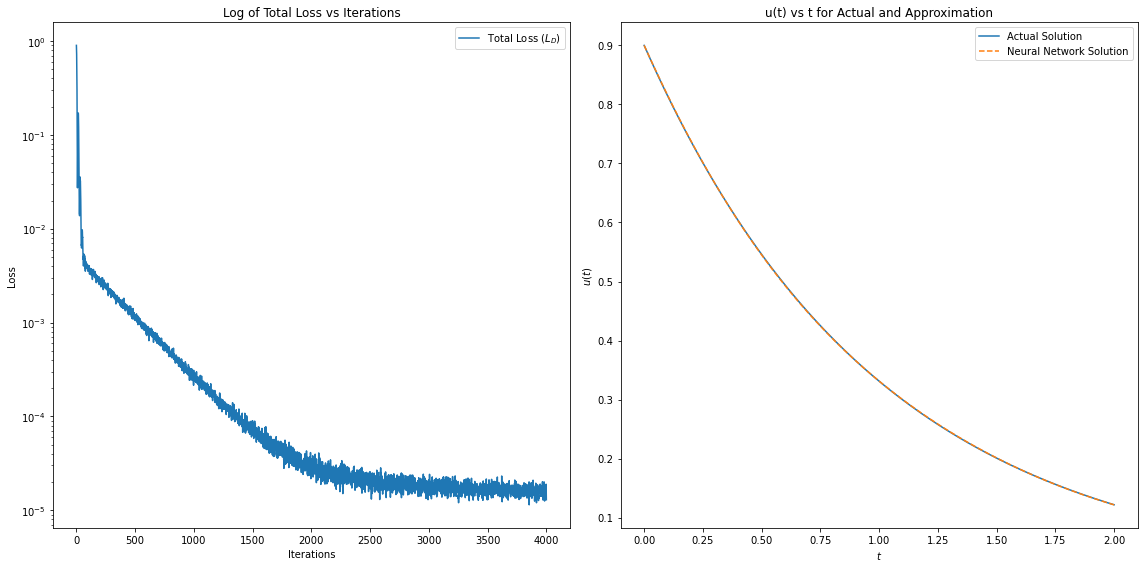


 Model 2: Loss = L_D + L_DD


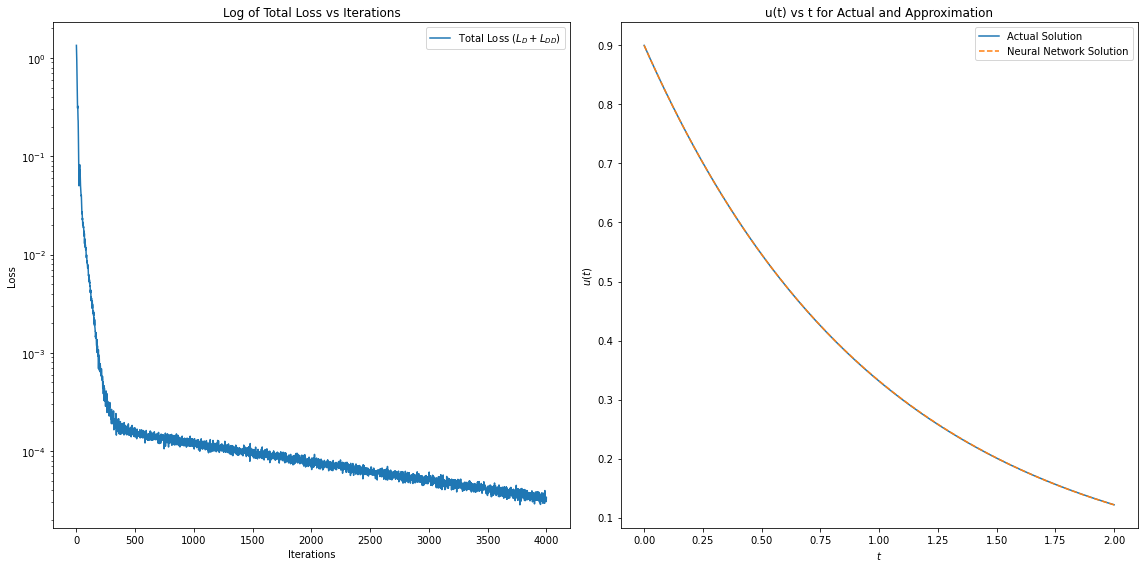


 Model 3: Loss = L_D + L_DD + L_DDD


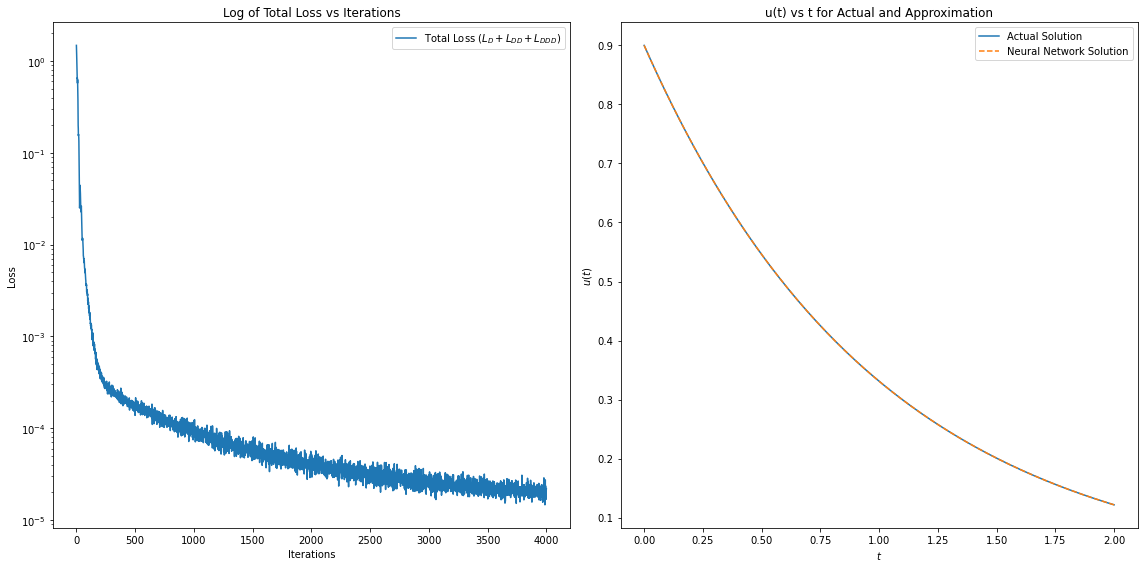

In [6]:
# plot overall loss and network solution for model which has a loss of the MSE (i.e. no higher order terms)
print("\n Model 1: Loss = L_D")
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
                       iterations=iterations, trained_model=trained_model_w1, 
                       train_losses=L_total_loss_w1, loss_label='Total Loss ($L_D$)')

# plot overall loss and network solution for model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
print("\n Model 2: Loss = L_D + L_DD")
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, 
                       iterations=iterations, trained_model=trained_model_w2, 
                       train_losses=L_total_loss_w2, loss_label='Total Loss ($L_D + L_{DD}$)')

# plot overall loss and network solution for model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
print("\n Model 3: Loss = L_D + L_DD + L_DDD")
plot_loss_and_solution(min_x=min_x, max_x=max_x, A=A, lambda_val=lambda_val, iterations=iterations, 
                       trained_model=trained_model_w3, 
                       train_losses=L_total_loss_w3, loss_label='Total Loss ($L_D + L_{DD} + L_{DDD}$)')


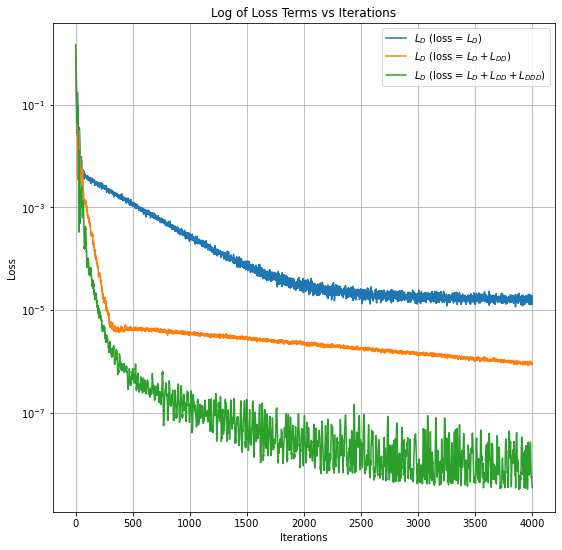

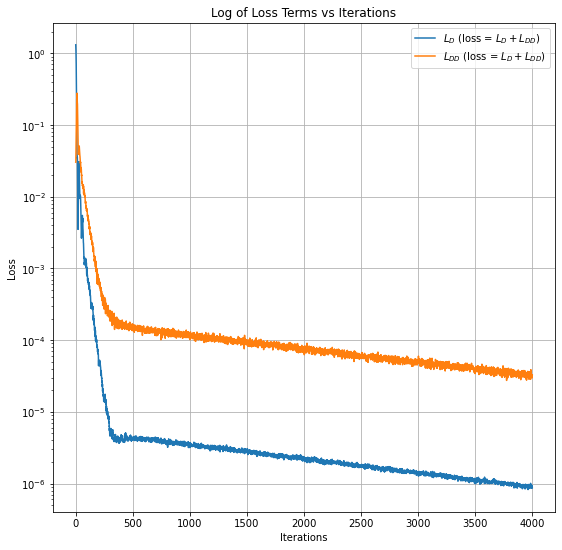

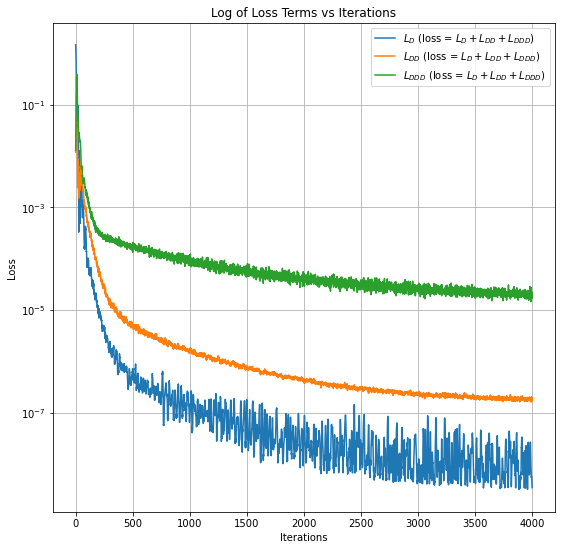

In [7]:
# plot of differential equation residual (L_D) for each updated model
plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D$)' : L_D_loss_w1,
                                        '$L_D$ (loss = $L_D + L_{DD}$)' : L_D_loss_w2,
                                        '$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : L_D_loss_w3})

# plot of L_D and L_DD when using a loss of the residual and the first derivative of the residual (i.e. one higher order term)
plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD}$)' : L_D_loss_w2, 
                                        '$L_{DD}$ (loss = $L_D + L_{DD}$)' : L_DD_loss_w2})

# plot of L_D, L_DD, and L_DDD when using a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : L_D_loss_w3, 
                                        '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : L_DD_loss_w3,
                                        '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : L_DDD_loss_w3})

In [8]:
# TODO 1: make the code generalizable so that any first-order diff-eq can be put in as opposed to just the simple exponential one

# TODO 2: ask about manufactured solution

# TODO 3: why is f_t and f_tt dependent on t and outputs? --> change code in loss to remove this

# TODO 5: ADD MSE PLOTS --> we know analytic solution, compare MSE now for 111, 100, 110 --> MSE will be very small

# TODO 6: keep adding L_D terms -->  keep adding L_D terms until diminishing returns are evident in plot 

# TODO 7: automatically compute derivatives as opposed to doing it by hand


# Done: 

# TODO 4: TIME CODE --> time the training correctly so we know time for L_D, L_DD, and L_DDD (entire run_model but only the relevant "L_D" terms)



# Appendix

### Questions: 

- what is the purpose of dividing by U_0 squared in loss?

- why would increasing A makes it more difficult for the network to get the solution?


### Notes:

- $u_t = lambda$ $t: A + t * model(t)$ is outdated, so we use $ u_t = lambda$ $t: A + (1 - exp(-t)) * model(t)$

- We are solving $\frac{du}{dt} + \lambda * u = 0$ where $f = -\lambda * u$

### Todo:

- Automatically compute derivatives as opposed to doing it by hand
- Try loss change by doing $L = \left(\frac{\frac{du}{dt} + \lambda u}{u_0}\right)^2$ or make $u_0$ equal to $\bar u$, in which case the denominator would have to be detached from the computational graph